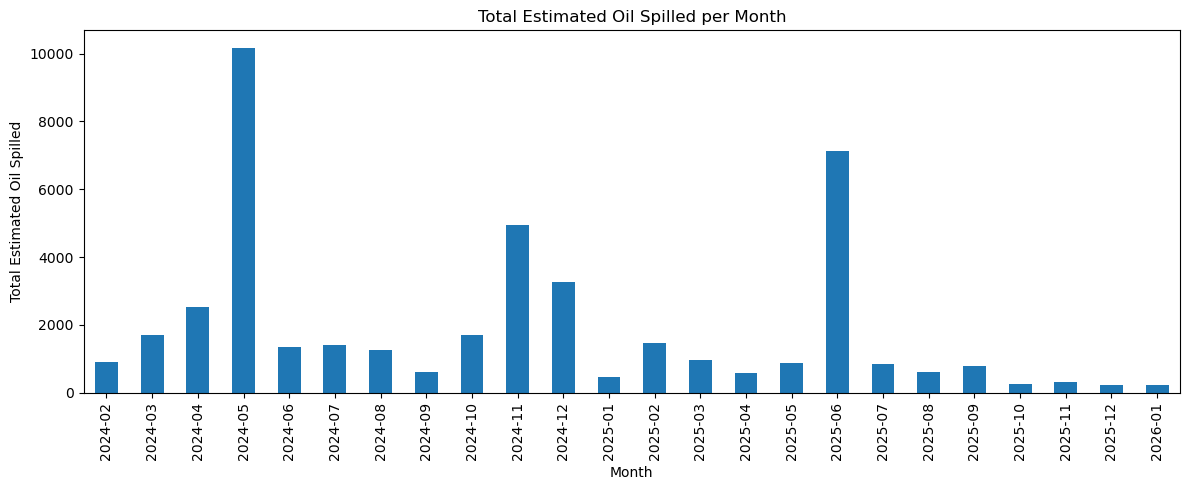

year_month
2024-05    10179.49071
2025-06     7124.45770
2024-11     4954.25728
2024-12     3264.88720
2024-04     2518.53473
Freq: M, Name: estimatedquantity, dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("NOSDRA_truncate.csv")

# Parse dates
df["incidentdate"] = pd.to_datetime(df["incidentdate"], errors="coerce")
df = df.dropna(subset=["incidentdate"])

# Ensure numeric quantity
df["estimatedquantity"] = pd.to_numeric(
    df["estimatedquantity"], errors="coerce"
).fillna(0)

# Create year-month column
df["year_month"] = df["incidentdate"].dt.to_period("M")

# Aggregate
monthly_spill = (
    df.groupby("year_month")["estimatedquantity"]
      .sum()
      .sort_index()
)

# Plot
plt.figure(figsize=(12, 5))
monthly_spill.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Total Estimated Oil Spilled")
plt.title("Total Estimated Oil Spilled per Month")
plt.tight_layout()
plt.show()

# Print top months
print(monthly_spill.sort_values(ascending=False).head(5))


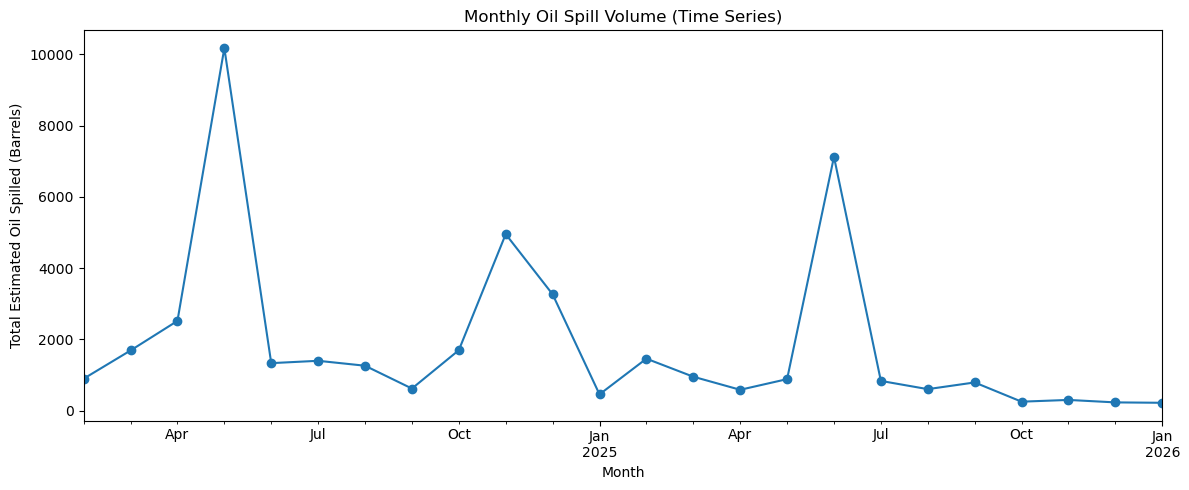

In [75]:
plt.figure(figsize=(12, 5))
monthly_spill.plot(marker="o")
plt.xlabel("Month")
plt.ylabel("Total Estimated Oil Spilled (Barrels)")
plt.title("Monthly Oil Spill Volume (Time Series)")
plt.tight_layout()
plt.show()


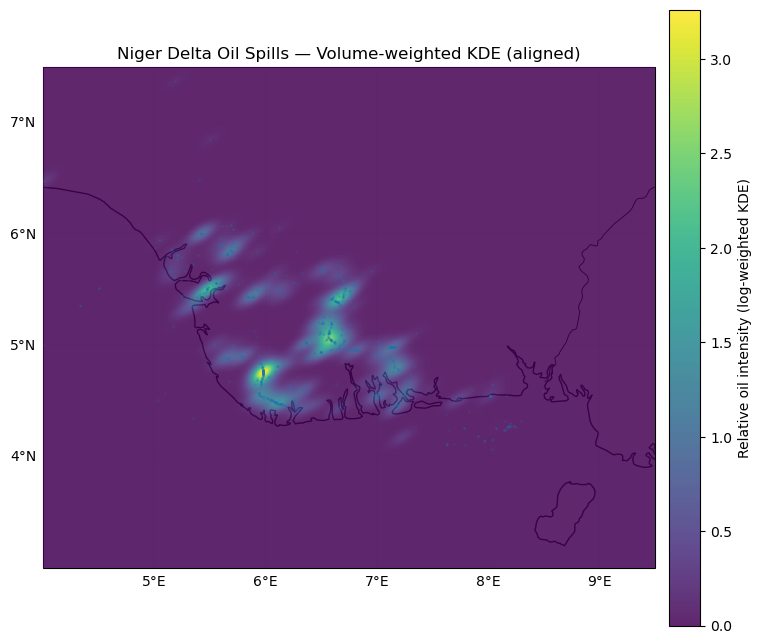

<Figure size 640x480 with 0 Axes>

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ----------------------------
# Load and clean data
# ----------------------------
df = pd.read_csv("NOSDRA_truncate.csv")

df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"]  = pd.to_numeric(df["latitude"],  errors="coerce")
df["estimatedquantity"] = pd.to_numeric(df["estimatedquantity"], errors="coerce")

df_clean = df.dropna(subset=["longitude", "latitude", "estimatedquantity"]).copy()
df_clean = df_clean[df_clean["estimatedquantity"] > 0]

# ----------------------------
# Map extent (UNCHANGED from your version)
# ----------------------------
minx, maxx = 4.0, 9.5
miny, maxy = 3.0, 7.5

# ----------------------------
# KDE (volume-weighted)
# ----------------------------
x = df_clean["longitude"].values
y = df_clean["latitude"].values

# Log-weighted volume so huge spills don't dominate everything
weights = np.log10(df_clean["estimatedquantity"].values + 1)

kde = gaussian_kde([x, y], weights=weights, bw_method=0.000002)

# KDE grid
nx, ny = 400, 400
xi = np.linspace(minx, maxx, nx)
yi = np.linspace(miny, maxy, ny)
xx, yy = np.meshgrid(xi, yi)

zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# ----------------------------
# Plot
# ----------------------------
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

# Base map (keep exactly)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.7)
ax.add_feature(cfeature.LAND, alpha=0.2)
ax.add_feature(cfeature.OCEAN, alpha=0.15)

# KDE heat layer
im = ax.imshow(
    zz,
    origin="lower",
    extent=[minx, maxx, miny, maxy],
    transform=ccrs.PlateCarree(),
    alpha=0.85,
    zorder=3
)

# Faint points on top (alignment proof)
ax.scatter(
    x, y,
    s=1,
    alpha=0.15,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# Gridlines with labels (alignment check)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title("Niger Delta Oil Spills — Volume-weighted KDE (aligned)")

cb = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cb.set_label("Relative oil intensity (log-weighted KDE)")

plt.tight_layout()
plt.show()

plt.savefig(
    "OilMap.png",
    dpi=300,
    bbox_inches="tight"
)



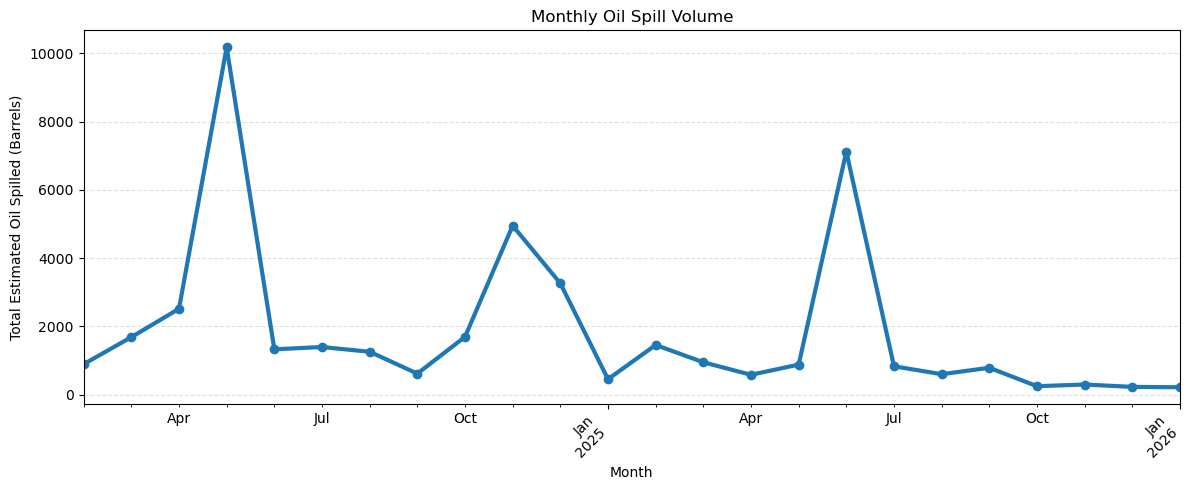

<Figure size 640x480 with 0 Axes>

In [84]:
plt.figure(figsize=(12, 5))

monthly_spill.plot(
    marker="o",
    linewidth=3
)

plt.xlabel("Month")
plt.ylabel("Total Estimated Oil Spilled (Barrels)")
plt.title("Monthly Oil Spill Volume")

# Subtle grid for readability
plt.grid(
    axis="y",
    linestyle="--",
    alpha=0.4
)



# Rotate x labels slightly so they breathe
plt.xticks(rotation=45, ha="right")

# Tight layout
plt.tight_layout()
plt.show()

plt.savefig(
    "monthly_oil_spill_volume.png",
    dpi=300,
    bbox_inches="tight"
)
